# CLIP

## 라이브러리 불러오기


In [ ]:
import torch
from PIL import Image
from transformers import CLIPProcessor, CLIPModel
import os
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm


## 구글 드라이브 연결

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 타겟 이미지와 유사한 이미지 선정


In [ ]:
# 1. CLIP 모델과 Processor 불러오기
device = "cuda" if torch.cuda.is_available() else "cpu"
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

In [ ]:
cached_embeddings = {}

# 1. 평균 풀링 함수
def average_pooling(features):
    return torch.mean(features, dim=0)

# 2. 이미지 로드 및 처리 함수
def load_and_process_image(image_path):
    image = Image.open(image_path)
    inputs = processor(images=image, return_tensors="pt", padding=True)
    return inputs['pixel_values'].to(device)  # GPU로 이동

# 3. 이미지 임베딩 추출 함수 (임베딩 값을 메모리에 저장)
def get_image_embedding(image_path):
    if image_path in cached_embeddings:
        return cached_embeddings[image_path]
    else:
        image_tensor = load_and_process_image(image_path)
        with torch.no_grad():
            image_features = model.get_image_features(image_tensor)
        cached_embeddings[image_path] = image_features
        return image_features

# 4. 폴더별 평균 풀링된 피처(1차원) 계산 함수
def calculate_average_features(base_folder):
    id_to_features = {}
    for folder_id in tqdm(os.listdir(base_folder), desc="Processing Folders"):
        folder_path = os.path.join(base_folder, folder_id)
        if os.path.isdir(folder_path):
            all_features = []
            for image_name in os.listdir(folder_path):
                image_path = os.path.join(folder_path, image_name)
                if image_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    image_embedding = get_image_embedding(image_path)
                    all_features.append(image_embedding)
            if all_features:
                # average pooling
                all_features = torch.stack(all_features)  # Tensor로 변환
                avg_features = average_pooling(all_features)
                
                # (중요) 여기서 바로 1차원으로 flatten
                # 1) view(-1)은 텐서를 1차원으로 펼치는 방법
                # 2) CPU로 옮긴 뒤 numpy array로 변환
                flattened_features = avg_features.view(-1).cpu().numpy()
                
                # id_to_features에 저장
                id_to_features[folder_id] = flattened_features

    return id_to_features

# 5. 결과 저장
def save_features_to_file(features_dict, output_file):
    with open(output_file, "wb") as f:
        pickle.dump(features_dict, f)
    print(f"Features saved to {output_file}")



In [ ]:
# gu = ['yangcheon','yeongdeungpo','dongjak','seocho','gangnam','songpa','seodaemun', 'nowon', 'jungnang', 'junggu', 'jongno', 'gwangjin', 'gwanak', 'guro', 'geumchun', 'gangseo', 'gangdong', 'gangbuk', 'eunpyeong', 'dongdaemun', 'dobong']
gu = ['dobong', 'gangdong','geumchun','guro', 'gwanak']

for g in gu:
    base_folder = f"/content/drive/MyDrive/문의는 DM/{g}/image/{g}_image"  # 이미지 폴더 경로
    output_file = f"/content/drive/MyDrive/문의는 DM/{g}.pkl"   # 저장할 파일명

    # 평균 풀링된 피처 계산
    features_dict = calculate_average_features(base_folder)

    # 파일로 저장
    save_features_to_file(features_dict, output_file)

Processing Folders: 100%|██████████| 229/229 [00:00<00:00, 1146.15it/s]


Features saved to /content/drive/MyDrive/문의는 DM/dobong.pkl


Processing Folders: 100%|██████████| 212/212 [08:20<00:00,  2.36s/it]


Features saved to /content/drive/MyDrive/문의는 DM/gangdong.pkl


Processing Folders: 100%|██████████| 196/196 [07:56<00:00,  2.43s/it]


Features saved to /content/drive/MyDrive/문의는 DM/geumchun.pkl


Processing Folders: 100%|██████████| 191/191 [08:40<00:00,  2.73s/it]


Features saved to /content/drive/MyDrive/문의는 DM/guro.pkl


Processing Folders: 100%|██████████| 215/215 [08:25<00:00,  2.35s/it]


Features saved to /content/drive/MyDrive/문의는 DM/gwanak.pkl


## 확인

In [ ]:
import pickle
import numpy as np
import os
import cv2
import random
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

# 유사도 계산 함수
def find_most_similar_features(features_dict, target_id):
    target_feature = features_dict[target_id]
    similarities = {}

    for other_id, feature in features_dict.items():
        if other_id != target_id:
            similarity = cosine_similarity([target_feature], [feature])[0][0]
            similarities[other_id] = similarity

    # 가장 유사한 ID 반환
    most_similar_id = max(similarities, key=similarities.get)
    return most_similar_id, similarities[most_similar_id]

# 이미지 시각화 함수
def visualize_images(base_folder, target_id, similar_id):
    target_folder = os.path.join(base_folder, target_id)
    similar_folder = os.path.join(base_folder, similar_id)

    target_images = [os.path.join(target_folder, img) for img in os.listdir(target_folder) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
    similar_images = [os.path.join(similar_folder, img) for img in os.listdir(similar_folder) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]

    max_images = max(len(target_images), len(similar_images))

    fig, axs = plt.subplots(2, max_images, figsize=(15, 8))

    if max_images == 1:
        axs = np.expand_dims(axs, axis=1)

    # 타겟 이미지 표시
    for i in range(max_images):
        if i < len(target_images):
            image = cv2.imread(target_images[i])
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            axs[0, i].imshow(image)
            axs[0, i].axis('off')
            axs[0, i].set_title(f"Target ({target_id})")
        else:
            axs[0, i].axis('off')

    # 유사 이미지 표시
    for i in range(max_images):
        if i < len(similar_images):
            image = cv2.imread(similar_images[i])
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            axs[1, i].imshow(image)
            axs[1, i].axis('off')
            axs[1, i].set_title(f"Similar ({similar_id})")
        else:
            axs[1, i].axis('off')

    plt.tight_layout()
    plt.show()


Target ID: 37391797
Most Similar ID: 18458689 (Similarity Score: 0.9161)


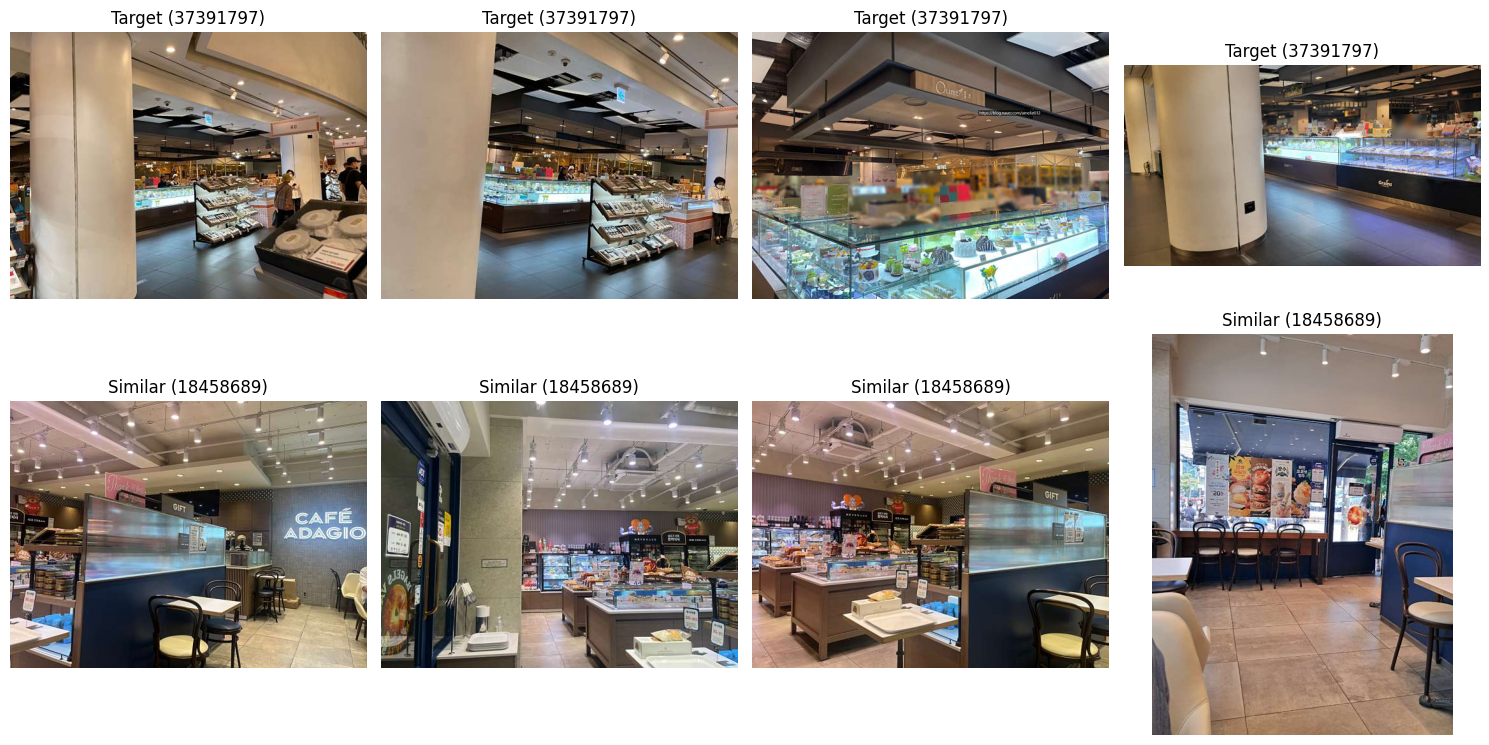

In [ ]:
import random
# 설정
pkl_file = "/content/drive/MyDrive/문의는 DM/guro.pkl"
base_folder = "/content/drive/MyDrive/문의는 DM/guro/image/guro_image"  # 이미지 폴더 경로

# pkl 파일 로드
with open(pkl_file, "rb") as f:
    features_dict = pickle.load(f)

# 임의의 타겟 ID 선택
target_id = random.choice(list(features_dict.keys()))
print(f"Target ID: {target_id}")

# 가장 유사한 ID 찾기
similar_id, similarity_score = find_most_similar_features(features_dict, target_id)
print(f"Most Similar ID: {similar_id} (Similarity Score: {similarity_score:.4f})")

# 이미지 시각화
visualize_images(base_folder, target_id, similar_id)

# Color based feature

In [ ]:
import os
import cv2
import numpy as np
import pickle
from tqdm import tqdm

In [ ]:
# ColorDescriptor 클래스 정의
class ColorDescriptor:
    def __init__(self, bins):
        self.bins = bins

    def describe(self, image):
        image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        features = []

        (h, w) = image.shape[:2]
        (cx, cy) = (int(w * 0.5), int(h * 0.5))
        segments = [(0, cx, 0, cy), (cx, w, 0, cy), (cx, w, cy, h), (0, cx, cy, h)]
        (ex, ey) = (int(w * 0.75) // 2, int(h * 0.75) // 2)

        ellipMask = np.zeros(image.shape[:2], dtype="uint8")
        cv2.ellipse(ellipMask, (cx, cy), (ex, ey), 0, 0, 360, 255, -1)

        for (startX, endX, startY, endY) in segments:
            cornerMask = np.zeros(image.shape[:2], dtype="uint8")
            cv2.rectangle(cornerMask, (startX, startY), (endX, endY), 255, -1)
            cornerMask = cv2.subtract(cornerMask, ellipMask)

            hist = self.histogram(image, cornerMask)
            features.extend(hist)

        hist = self.histogram(image, ellipMask)
        features.extend(hist)

        return features

    def histogram(self, image, mask):
        hist = cv2.calcHist([image], [0, 1, 2], mask, self.bins, [0, 180, 0, 256, 0, 256])
        hist = cv2.normalize(hist, hist).flatten()
        return hist

# 평균 풀링 함수
def average_pooling(features):
    return np.mean(features, axis=0)

# 각 폴더에 대해 특징 계산 및 저장
def calculate_color_features(base_folder, output_file, bins):
    cd = ColorDescriptor(bins)
    id_to_features = {}

    for folder_id in tqdm(os.listdir(base_folder), desc="Processing Folders"):
        folder_path = os.path.join(base_folder, folder_id)
        if os.path.isdir(folder_path):
            all_features = []
            for image_name in os.listdir(folder_path):
                image_path = os.path.join(folder_path, image_name)
                if image_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    image = cv2.imread(image_path)
                    if image is not None:
                        features = cd.describe(image)
                        all_features.append(features)

            if all_features:
                avg_features = average_pooling(np.array(all_features))
                id_to_features[folder_id] = avg_features

    with open(output_file, "wb") as f:
        pickle.dump(id_to_features, f)
    print(f"Features saved to {output_file}")



In [ ]:
# gu = ['yangcheon','yeongdeungpo','dongjak','seocho','gangnam','songpa','seodaemun', 'nowon', 'jungnang', 'junggu', 'jongno', 'gwangjin', 'gwanak', 'guro', 'geumchun', 'gangseo', 'gangdong', 'gangbuk', 'eunpyeong', 'dongdaemun', 'dobong']
gu = ['dobong', 'gangdong','geumchun','guro', 'gwanak']
for g in gu:
    base_folder = f"/content/drive/MyDrive/문의는 DM/{g}/image/{g}_image"  # 이미지 폴더 경로
    output_file = f"/content/drive/MyDrive/문의는 DM/{g}_color.pkl"  # 저장할 파일명
    bins = (8, 12, 3)  # Hue, Saturation, Value의 히스토그램 bins

    calculate_color_features(base_folder, output_file, bins)

Processing Folders: 100%|██████████| 229/229 [00:07<00:00, 30.02it/s]


Features saved to /content/drive/MyDrive/문의는 DM/dobong_color.pkl


Processing Folders: 100%|██████████| 212/212 [00:08<00:00, 25.52it/s]


Features saved to /content/drive/MyDrive/문의는 DM/gangdong_color.pkl


Processing Folders: 100%|██████████| 196/196 [00:08<00:00, 22.52it/s]


Features saved to /content/drive/MyDrive/문의는 DM/geumchun_color.pkl


Processing Folders: 100%|██████████| 191/191 [00:08<00:00, 23.61it/s]


Features saved to /content/drive/MyDrive/문의는 DM/guro_color.pkl


Processing Folders: 100%|██████████| 215/215 [00:09<00:00, 23.04it/s]


Features saved to /content/drive/MyDrive/문의는 DM/gwanak_color.pkl


In [ ]:
import pickle
import numpy as np
import os
import cv2
import random
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

# 유사도 계산 함수
def find_most_similar_features(features_dict, target_id):
    target_feature = features_dict[target_id]
    similarities = {}

    for other_id, feature in features_dict.items():
        if other_id != target_id:
            similarity = cosine_similarity([target_feature], [feature])[0][0]
            similarities[other_id] = similarity

    # 가장 유사한 ID 반환
    most_similar_id = max(similarities, key=similarities.get)
    return most_similar_id, similarities[most_similar_id]

# 이미지 시각화 함수
def visualize_images(base_folder, target_id, similar_id):
    target_folder = os.path.join(base_folder, target_id)
    similar_folder = os.path.join(base_folder, similar_id)

    target_images = [os.path.join(target_folder, img) for img in os.listdir(target_folder) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
    similar_images = [os.path.join(similar_folder, img) for img in os.listdir(similar_folder) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]

    # 타겟 이미지와 유사 이미지 개수 중 최대값 계산
    max_images = max(len(target_images), len(similar_images))

    # Matplotlib으로 시각화
    fig, axs = plt.subplots(2, max_images, figsize=(15, 8))

    # axs가 1차원 배열이 아닌 경우 처리
    if max_images == 1:
        axs = np.expand_dims(axs, axis=1)

    # 타겟 이미지 표시
    for i in range(max_images):
        if i < len(target_images):
            image = cv2.imread(target_images[i])
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            axs[0, i].imshow(image)
            axs[0, i].axis('off')
            axs[0, i].set_title(f"Target ({target_id})")
        else:
            axs[0, i].axis('off')

    # 유사 이미지 표시
    for i in range(max_images):
        if i < len(similar_images):
            image = cv2.imread(similar_images[i])
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            axs[1, i].imshow(image)
            axs[1, i].axis('off')
            axs[1, i].set_title(f"Similar ({similar_id})")
        else:
            axs[1, i].axis('off')

    plt.tight_layout()
    plt.show()



## 확인

Target ID: 1113698367
Most Similar ID: 969214129 (Similarity Score: 0.7915)


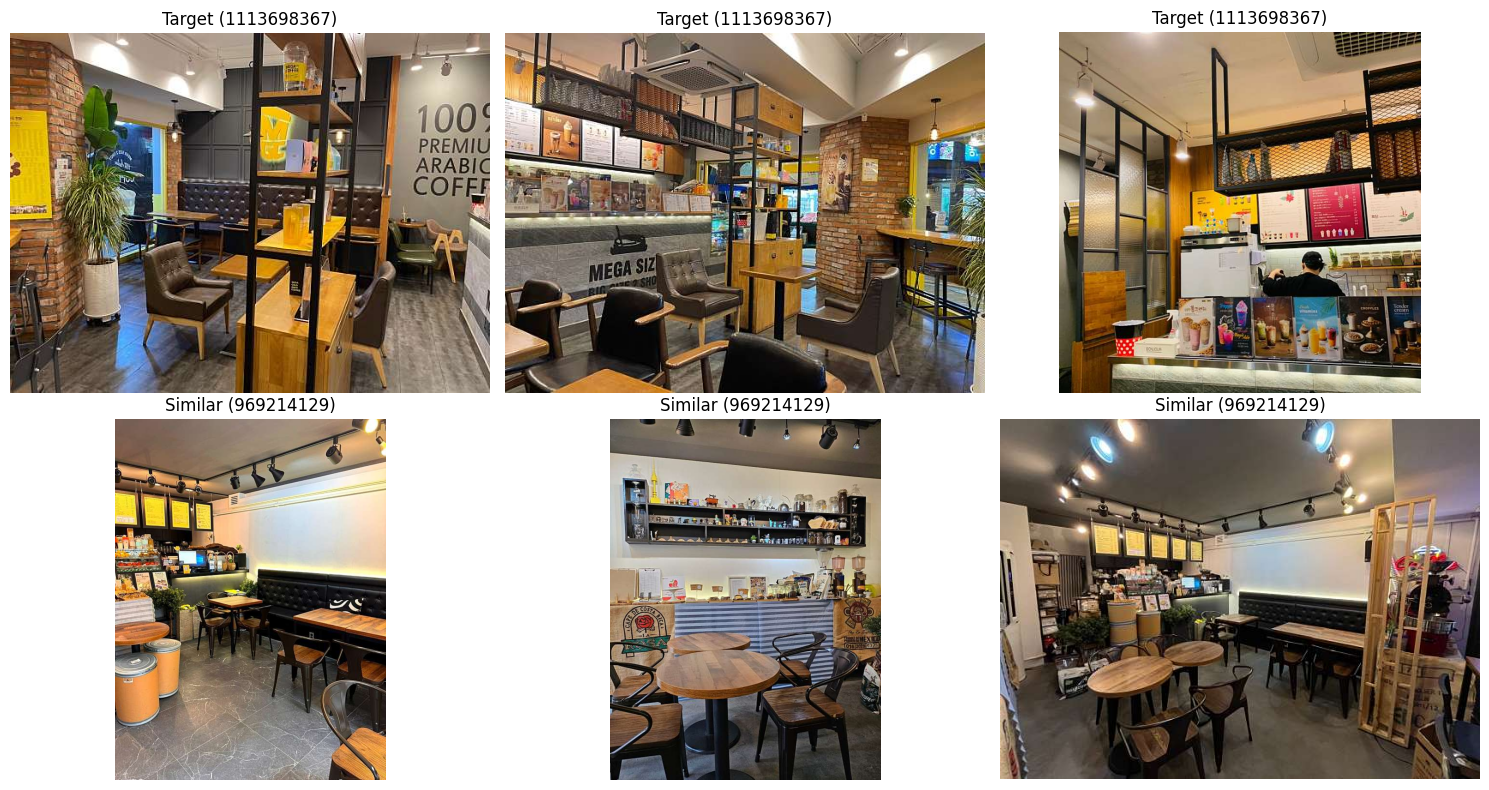

In [ ]:

# 설정
pkl_file = "/content/drive/MyDrive/문의는 DM/guro_color.pkl"
base_folder = "/content/drive/MyDrive/문의는 DM/guro/image/guro_image"  # 이미지 폴더 경로

# pkl 파일 로드
with open(pkl_file, "rb") as f:
    features_dict = pickle.load(f)

# 임의의 타겟 ID 선택
target_id = random.choice(list(features_dict.keys()))
print(f"Target ID: {target_id}")

# 가장 유사한 ID 찾기
similar_id, similarity_score = find_most_similar_features(features_dict, target_id)
print(f"Most Similar ID: {similar_id} (Similarity Score: {similarity_score:.4f})")

# 이미지 시각화
visualize_images(base_folder, target_id, similar_id)